<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [3]:
!nvidia-smi

Wed May 26 20:02:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
!pip install SimpleITK
%cd /content/segmentation-of-pelvic-bone/src

Cloning into 'segmentation-of-pelvic-bone'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 205 (delta 113), reused 138 (delta 63), pack-reused 0
Receiving objects: 100% (205/205), 3.26 MiB | 32.70 MiB/s, done.
Resolving deltas: 100% (113/113), done.
     |████████████████████████████████| 47.4MB 107kB/s 
/content/segmentation-of-pelvic-bone/src


In [5]:
!git pull

Already up to date.


In [6]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [7]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

## Load Data

In [8]:
%%time
importlib.reload(ana)
data = ana.PelvicData(root_path=PATH)

CPU times: user 12.9 s, sys: 3.46 s, total: 16.4 s
Wall time: 25.6 s


In [9]:
data.cmn_img_3c[42].shape

(291, 512, 512, 3)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(data.X_train_3C, data.y_train, test_size=0.1, random_state=42, stratify=data.y_train)
print(f"X train shape:{X_train.shape}, y train shape:{y_train.shape} ")
print(f"X val shape:{X_val.shape}, y val shape:{y_val.shape} ")

X train shape:(772, 512, 512, 3), y train shape:(772,) 
X val shape:(86, 512, 512, 3), y val shape:(86,) 


## ResNet V2

In [61]:
data_augmentation = tfk.Sequential([
  tfkl.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tfkl.experimental.preprocessing.RandomRotation(0.2),
])

In [79]:
input = tfkl.Input([None, None, 3], dtype = tf.int16)
x = tf.cast(input, tf.float32)
x = tf.image.per_image_standardization(x)
vgg_model = tfk.applications.VGG16(weights="imagenet", include_top=False, pooling="max")
vgg_output = vgg_model(x)
hidden_layer = tfkl.Dense(512, activation='relu')(vgg_output)
hl_reg = tfkl.Dropout(0.4)(hidden_layer)
# hidden_layer = tfkl.Dense(256, activation='relu')(hl_reg)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [71]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast_9 (TFOpLambda)       (None, None, None, 3)     0         
_________________________________________________________________
tf.image.per_image_standardi (None, None, None, 3)     0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513 

### Training 

In [80]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer="SGD", loss='binary_crossentropy', 
              metrics=['acc'])

In [81]:
checkpoint_filepath = PATH + '/checkpoint/vgg/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/25
25/25 [==============================] - 9s 318ms/step - loss: 0.4620 - acc: 0.8316 - val_loss: 0.3308 - val_acc: 0.9535
Epoch 2/25
25/25 [==============================] - 8s 308ms/step - loss: 0.2893 - acc: 0.8886 - val_loss: 0.2127 - val_acc: 0.9535
Epoch 3/25
25/25 [==============================] - 8s 309ms/step - loss: 0.2807 - acc: 0.8873 - val_loss: 0.2544 - val_acc: 0.8837
Epoch 4/25
25/25 [==============================] - 8s 309ms/step - loss: 0.2312 - acc: 0.9067 - val_loss: 0.1821 - val_acc: 0.8837
Epoch 5/25
25/25 [==============================] - 8s 309ms/step - loss: 0.2090 - acc: 0.9054 - val_loss: 0.1459 - val_acc: 0.9186
Epoch 6/25
25/25 [==============================] - 8s 309ms/step - loss: 0.1783 - acc: 0.9236 - val_loss: 0.1486 - val_acc: 0.8837
Epoch 7/25
25/25 [==============================] - 8s 309ms/step - loss: 0.1562 - acc: 0.9301 - val_loss: 0.1490 - val_acc: 0.9767
Epoch 8/25
25/25 [==============================] - 8s 309ms/step - loss: 0.

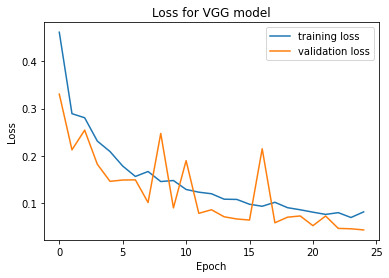

In [82]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

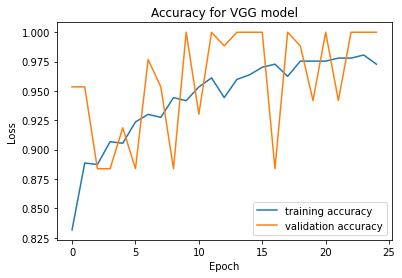

In [83]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title("Accuracy for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Performance on Common Images

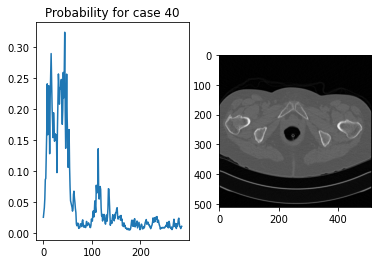

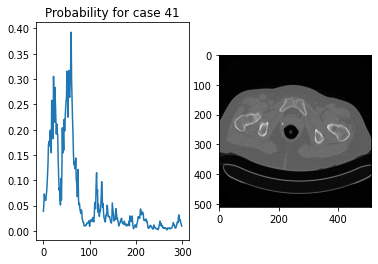

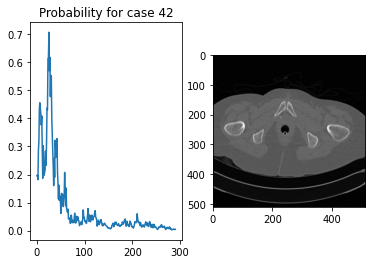

CPU times: user 9.33 s, sys: 61.8 ms, total: 9.39 s
Wall time: 8.83 s


In [84]:
%%time
for id, cmn_img in data.cmn_img_3c.items():
  y_pred = model.predict(cmn_img)
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()

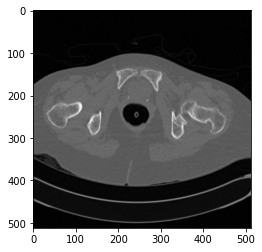

In [20]:
plt.imshow(data.cmn_img[42][48], cmap="gray")

In [22]:
model.predict(data.cmn_img_3c[42][48].reshape(1,512,512,3))

array([[0.]], dtype=float32)